In [1]:
import os
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print(os.getcwd())

path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print(os.getcwd())

C:\Users\danie\Documents\COGS402\cogs402longformer\src\training_notebooks
C:\Users\danie\Documents\COGS402\cogs402longformer\src
C:\Users\danie\Documents\COGS402\cogs402longformer


This notebook contains the training pipeline for the [hyperpartisan news dataset](https://huggingface.co/datasets/hyperpartisan_news_detection). Specifically, this notebook serves to train the [BERT](https://huggingface.co/bert-base-cased) model as a baseline to compare against the longformer model we train. To train this dataset, we import the longformer tokenizer and the base model from the [Huggingface Hub] (https://huggingface.co/allenai/longformer-base-4096) in order to fine-tune the model for our needs. The hyperpartisan dataset is massive, with 600k training and validation examples so we will only be taking a subset of the data. Of course the amount of data we select may be different from the amount you want, and it is easy to adjust if needed.

## Import model, tokenizer, and datasets

Here we import the hyperpartisan news dataset from the huggingface hub.

In [2]:
import datasets 
#load dataset
dataset = datasets.load_dataset('hyperpartisan_news_detection', 'bypublisher')

Reusing dataset hyperpartisan_news_detection (C:\Users\danie\.cache\huggingface\datasets\hyperpartisan_news_detection\bypublisher\1.0.0\7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012)


  0%|          | 0/2 [00:00<?, ?it/s]

This block of code imports the base model and tokenizer that we will use to fine-tune our model. We also include code demonstrating how to import a model from your own hub (in this case danielhou13) and how to import from a checkpoint stored in your local directory.

In [5]:
#import huggingface models
from transformers import BertForSequenceClassification, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

We then separate the two datasets

In [6]:
train_ds = dataset["train"]
eval_ds = dataset["validation"]

The Dataset is huge, so we take a subset of the data for both splits. Alternatively, if you have a split of the data stored on disk that you want to use for training, you can avoid using the following block of code.

In [7]:
## Take subset of data
train_size = 20000
val_size = 2500
import numpy as np

train_indices = np.random.randint(0, len(train_ds), train_size)
val_indices = np.random.randint(0, len(eval_ds), val_size)
train_ds = train_ds.select(train_indices)
eval_ds = eval_ds.select(val_indices)

In [6]:
# train_ds.save_to_disk("data/train_news")

We can import a training set or a validation set if you want to keep your data consistent by running the following command. Simply replace "data/train_news" with a path to your own data.

In [8]:
train_ds = datasets.load_from_disk("data/train_news")
print(train_ds)

Dataset({
    features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
    num_rows: 20000
})


Another option for not having to deal with such a massive dataset is to store the subset of data as a new dataset for reproducability. The following two blocks of code connects to your personal huggingface account and saves your newly created dataset onto a repository. From here, we can easily access this dataset by importing the dataset (example above) rather than having to convert from a .csv file to a huggingface dataset. 

More information about authentication tokens can be found on [here](https://huggingface.co/course/chapter4/3?fw=pt#using-the-pushtohub-api) on the huggingface website, which gives a brief summary of how to properly connect to your huggingface account.

In [ ]:
# dataset["train"] = train_ds
# dataset["validation"] = eval_ds
# print(dataset)

In [15]:
# upload this dataset to huggingface
# from huggingface_hub import notebook_login

# notebook_login()

In [37]:
# dataset.push_to_hub("danielhou13/cogs402dataset2")

Pushing split train to the Hub.
The repository already exists: the `private` keyword argument will be ignored.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split validation to the Hub.
The repository already exists: the `private` keyword argument will be ignored.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

If you have stored a subset of the data you wish to use, you can import the dataset by replacing the path (danielhou13/cogs402dataset2 with your own. Then, we can grab the two splits.

In [10]:
dataset2 = datasets.load_dataset("danielhou13/cogs402dataset2")
train_ds = dataset2["train"]
eval_ds = dataset2["validation"]

Using custom data configuration danielhou13--cogs402dataset2-5e8e10311524cdf9
Reusing dataset parquet (C:\Users\danie\.cache\huggingface\datasets\parquet\danielhou13--cogs402dataset2-5e8e10311524cdf9\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/2 [00:00<?, ?it/s]

## Exploratory Data Analysis

We want to make sure that the number of classes are roughly the same for the training set, otherwise we would have a class imbalance. We first want to convert the dataset into pandas, which will allow us to easily perform our exploratory data analysis.

In [11]:
import pandas as pd

train_ds.set_format(type="pandas")
df = train_ds[:]
df["Words Per article"] = df["text"].str.split().apply(len)
df.head()

,text,title,hyperpartisan,url,published_at,bias,Words Per article
0,<p>US Treasury Secretary Timothy F. Geithner t...,Geithner defends his role in LIBOR-rigging sca...,False,https://pri.org/stories/2012-07-25/geithner-de...,2012-07-25,3,306
1,<p>.......... .......... .......... .............,"George Beall, who led prosecution of Vice Pres...",False,https://abqjournal.com/930680/george-beall-who...,,2,779
2,<p>Queen Elizabeth II is known to often times ...,The Queen Mother Is Almost Shot In Her Own Bac...,True,http://offthemainpage.com/2017/01/05/the-queen...,2017-01-05,4,180
3,<p>.......... .......... .......... .............,Rollover accident kills driver,False,https://abqjournal.com/535068/rollover-acciden...,,2,139
4,"<p>For the first time in American history, the...",HS Graduation Rate Hits Historic High. Obama C...,True,https://dailywire.com/news/10026/hs-graduation...,2016-10-18,0,373


We can see that by randomly selecting 20,000 examples from the training set, we still have a balanced dataset to train on. The distribution is not a perfect 50/50, as we see the positive class (they are news articles) have slightly more examples than the negative class (they are not news articles).

In [12]:
df["hyperpartisan"].value_counts(ascending=True)

False     9904
True     10096
Name: hyperpartisan, dtype: int64

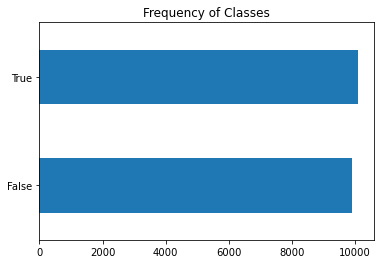

In [13]:
import matplotlib.pyplot as plt

df["hyperpartisan"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Lets find out the min, max and average number of words per article. The number of tokens would be higher but it gives us an estimate of the max number of tokens we want our tokenizer to operate on. The max seems to be about 1750 words so 4096 tokens should be more than enough tokens to capture every word.

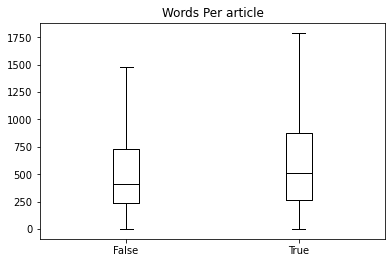

In [14]:
df.boxplot("Words Per article", by="hyperpartisan", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Now that we are done with our exploratory data analysis, we want to convert the dataset from pandas back to the huggingface dataset format.

In [15]:
train_ds.reset_format()

## Preprocessing

We need to convert the dataset into a pytorch compatible format so we need to change the target column's (hyperpartisan) name into "labels" and add it into our dataset

In [16]:
#convert hyperpartisan to correct format (from true/false to 1/0)
labels = map(int, train_ds['hyperpartisan'])
labels = list(labels)

labels2 = map(int, eval_ds['hyperpartisan'])
labels2 = list(labels2)

In [17]:
#add the columns to the dataset
train_ds = train_ds.add_column("labels", labels)
eval_ds = eval_ds.add_column("labels", labels2)

We then tokenize the text in the dataset. This may take a long time depending on how many tokens you wish to use. 

In [22]:
#trainer API auto uses dynamic padding... supposedly
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True)

In [23]:
#tokenize the data
train_dataset = train_ds.map(tokenize, load_from_cache_file=False)
val_dataset = eval_ds.map(tokenize, load_from_cache_file=False)


0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

Finally we change the columns we want into pytorch tensors and remove the unnecessary columns.

In [24]:
#remove unnessesary columns and convert needed ones to torch format
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
val_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])

train_dataset = train_dataset.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])
val_dataset = val_dataset.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])
print(train_dataset)


Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 20000
})


## Training

We train 2 epochs and use gradient accumulation, gradient checkpointing and mixed precision in order to lower the memory requirements of the training. These methods, simply put, help your model reduce the amount of memory required to train the model. Given that each example may have up to 4098 tokens, the training uses a lot of memory, so we try to minimize the amount needed. This may have an impact on our training speed, so adjust the parameters based on your GPU.

When passing in more than one example, you need to make sure both examples are the same length, so we pad to the longest example.

In [25]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Make sure you're using connecting to your GPU if you have one

In [26]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [27]:
#create checkpointing folder if doesn't exist
if not os.path.exists("models"):
    os.mkdir("models")

Here we set the parameters for our training. Most of these are default parameters, shown for demonstration purposes. We train for 2 epochs and after every epoch, we do a quick checkup on the performance. We set mixed precision (fp16), gradient accumulation and gradient checkpointing to true for memory saving purposes.

In [28]:
from transformers import Trainer, TrainingArguments

batch_size = 1
gradient_acc = 4
logging_steps = (len(train_dataset) // batch_size) // gradient_acc
model_name = f"bert-finetuned_news"
training_args = TrainingArguments(output_dir=f"models/{model_name}",
                                  num_train_epochs = 2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  push_to_hub=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  fp16=True,
                                  gradient_accumulation_steps=gradient_acc,
                                  gradient_checkpointing=True,
                                  save_strategy = "epoch",
                                  report_to="none") 

In [29]:
print(logging_steps)

5000


We use f1-score and accuracy as fairly general metrics.

In [30]:
#create the metrics we want to find out, can import othe things like precision, recall if needed
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

The training arguments are to define the hyperparameters of your fine-tuning but here we are passing in the parameters we want to train.

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator = data_collator
)


Here we do the actual training.

In [27]:
trainer.train()

C:\Users\danie\miniconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.355100,0.279735,0.927600,0.927603
2,0.210200,0.298892,0.931600,0.931603


TrainOutput(global_step=10000, training_loss=0.28261846923828127, metrics={'train_runtime': 2909.6334, 'train_samples_per_second': 13.747, 'train_steps_per_second': 3.437, 'total_flos': 9648961761018360.0, 'train_loss': 0.28261846923828127, 'epoch': 2.0})

In [32]:
preds_output = trainer.predict(val_dataset)

## Results

In [33]:
preds_output.metrics

{'test_loss': 0.298891544342041,
 'test_accuracy': 0.9316,
 'test_f1': 0.931602901464034,
 'test_runtime': 47.4837,
 'test_samples_per_second': 52.65,
 'test_steps_per_second': 52.65}

Overall the model does well at predicting whether an example is a news article or not. Our accuracy is 0.3 while our f1-score is also 0.93.

In [34]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = np.array(val_dataset["labels"])

The classification report using the predicted labels given to us by the model and the actual labels from our dataset tells us how the model does in terms of recall, precision, f1-score and accuracy for both classes. It seems it does roughly the same (when considering rounding) for precision, recall, f1-score and accuracy.

In [35]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_true, y_preds, target_names=["false", "true"]
    )
)

              precision    recall  f1-score   support

       false       0.93      0.93      0.93      1279
        true       0.93      0.93      0.93      1221

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



We can use a confusion matrix to find out how many of these examples were wrongly labeled and how many were properly predicted. We use sklearn's confusion matrix function. It seems that there were more instances of false positives (predicted true when it should be false) compared to false negatives (predicted false when it should be true).

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

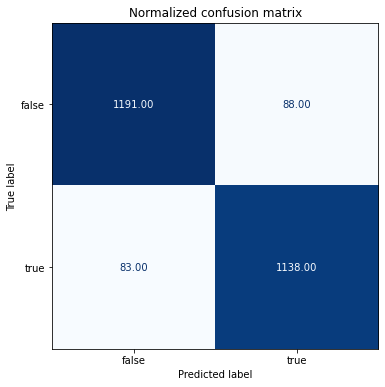

(2500,)
(2500,)


In [37]:
plot_confusion_matrix(y_preds, y_true, labels=["false", "true"])
print(y_true.shape)
print(y_preds.shape)

Our validation set size is a little low so here we are trying on a larger validation set size (15000 vs 5000). We are doing the exact same preprocessing as in the previous section.

In [38]:
## Take subset of data
eval_ds = dataset["validation"]
val_size2 = 15000
val_indices2 = np.random.randint(0, len(eval_ds), val_size2)
val_ds2 = eval_ds.select(val_indices2)

In [39]:
labels3 = map(int, val_ds2['hyperpartisan'])
labels3 = list(labels3)

In [40]:
val_ds2 = val_ds2.add_column("labels", labels3)

Loading cached processed dataset at C:\Users\danie\.cache\huggingface\datasets\hyperpartisan_news_detection\bypublisher\1.0.0\7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012\cache-9847eae9f30db4ec.arrow


In [41]:
val_dataset2 = val_ds2.map(tokenize, load_from_cache_file=False)

0ex [00:00, ?ex/s]

In [42]:
#remove unnessesary columns and convert needed ones to torch format
val_dataset2.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
val_dataset2 = val_dataset2.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])

In [43]:
preds_output2 = trainer.predict(val_dataset2)

We find that our metrics are a little lower than our above trial with less amount of examples, but it is a marginal difference (0.01 rounded), so it seems it is still doing fairly well.

In [44]:
y_preds2 = np.argmax(preds_output2.predictions, axis=1)
y_true2 = np.array(val_dataset2["labels"])

In [45]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_true2, y_preds2, target_names=["false", "true"]
    )
)

              precision    recall  f1-score   support

       false       0.94      0.93      0.93      7498
        true       0.93      0.94      0.93      7502

    accuracy                           0.93     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.93      0.93     15000



The main difference is that there seems to be more false positives now (the model predicted true but was actually false) when compared to false negatives whereas the smaller validation set was the opposite. 

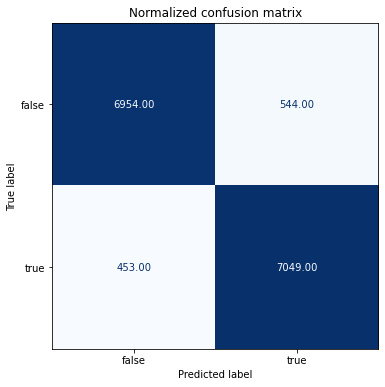

(15000,)
(15000,)


In [46]:
plot_confusion_matrix(y_preds2, y_true2, labels=["false", "true"])
print(y_true2.shape)
print(y_preds2.shape)

## Upload to huggingface

Now that we are done fine-tuning the model and are satisfied with the chosen hyperparameters, we can upload this model to huggingface so we can easily access it in other notebooks/projects. Using the `push_to_hub` function, we pass in our username/name-we-want to create a new repository for your model. If you are wanting to save over a previous model, you can pass in that original repository's name like so: username/original-project. 

More information about authentication tokens can be found on [here](https://huggingface.co/course/chapter4/3?fw=pt#using-the-pushtohub-api) on the huggingface website, which gives a brief summary of how to properly connect to your huggingface account.

In [47]:
from huggingface_hub import notebook_login

notebook_login()

In [48]:
# upload model to huggingface for storage
# replace danielhou13 with personal user
model.push_to_hub("danielhou13/bert-finetuned-news")

C:\Users\danie\miniconda3\lib\site-packages\huggingface_hub\hf_api.py:1001: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(
Cloning https://huggingface.co/danielhou13/bert-finetuned-news into local empty directory.


Upload file pytorch_model.bin:   0%|          | 32.0k/413M [00:00<?, ?B/s]

To https://huggingface.co/danielhou13/bert-finetuned-news
   5c281f9..7266dda  main -> main



'https://huggingface.co/danielhou13/bert-finetuned-news/commit/7266dda9f50e327440994ee318f4eef35aec501d'

Now you can easily access both the model and the dataset used to fine-tune the model for any other tasks you wish using the import functions described in the import section.